Import necessary modules:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from wordcloud import WordCloud

- Import 'csv' file

In [2]:
df = pd.read_csv("./Tweets.csv")

- Get first five records

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


- Filter out colums for further work

<h1>Exploratory data analysis</h1>

<h3> Most preferable airlines </h3>

- List of airlines

In [4]:
airlines = df['airline'].unique()

print("Airlines:", airlines)

Airlines: ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']


- Positive, neutral and negative <code>airline_sentiment</code> per <code>airline</code>

In [5]:
def get_airline_sentiment(df, airlines):
    positives = []
    negatives = []
    neutrals = []

    for airline in airlines:
        positive = df.query('@airline == airline and airline_sentiment == "positive"')['tweet_id'].count()
        negative = df.query('@airline == airline and airline_sentiment == "negative"')['tweet_id'].count()
        neutral = df.query('@airline == airline and airline_sentiment == "neutral"')['tweet_id'].count()
        
        positives.append(positive)
        negatives.append(negative)
        neutrals.append(neutral)
          
    return positives, negatives, neutrals
        

     
positives, negatives, neutrals = get_airline_sentiment(df, airlines)

sentiment_airlines_df = pd.DataFrame(index = airlines);
sentiment_airlines_df['neutrals'] = neutrals
sentiment_airlines_df['positives'] = positives
sentiment_airlines_df['negatives'] = negatives
sentiment_airlines_df

,neutrals,positives,negatives
Virgin America,171,152,181
United,697,492,2633
Southwest,664,570,1186
Delta,723,544,955
US Airways,381,269,2263
American,463,336,1960


- Positive, neutral and negative <code>airline_sentiment</code> per <code>airline</code> in percentage (%)

In [6]:
sentiment_airlines_percentage_df = pd.DataFrame(index = airlines);
sentiment_airlines_percentage_df['neutrals (%)'] = list(map(lambda n: n / sum(neutrals) * 100, neutrals))
sentiment_airlines_percentage_df['positives (%)'] = list(map(lambda n: n / sum(positives) * 100, positives))
sentiment_airlines_percentage_df['negatives (%)'] = list(map(lambda n: n / sum(negatives) * 100, negatives))
sentiment_airlines_percentage_df

,neutrals (%),positives (%),negatives (%)
Virgin America,5.517909,6.432501,1.972107
United,22.491126,20.820990,28.688167
Southwest,21.426267,24.121879,12.922205
Delta,23.330106,23.021583,10.405317
US Airways,12.294288,11.383834,24.656788
American,14.940303,14.219213,21.355415


<strong>According to this analysis, the most preferable airline is Southwest. Virgin America is the airline with the lowest negative feedbacks.</strong>

- Positive, neutral and negative <code>airline_sentiment</code> per <code>airline</code>

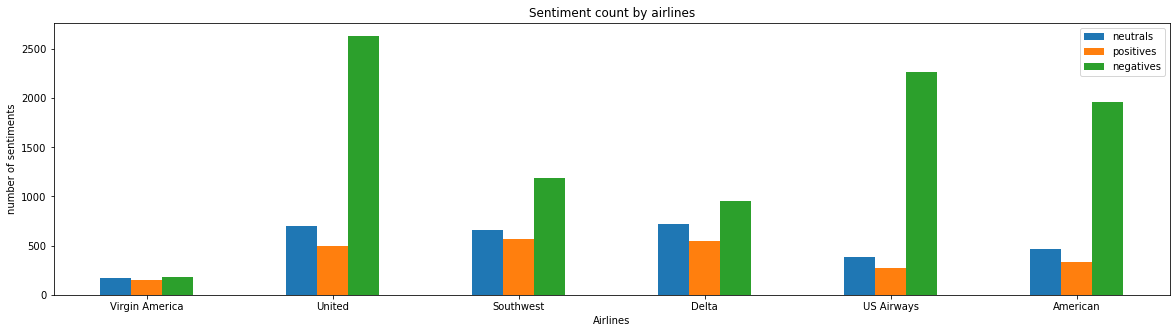

In [7]:
sentiment_airlines_df.plot.bar(rot=0, figsize=(20,5))

plt.title('Sentiment count by airlines')
plt.xlabel('Airlines')
plt.ylabel('number of sentiments')

plt.show()

In [8]:
sentiment_df = df[['airline_sentiment', 'text']].copy()

- Get first five records

In [9]:
sentiment_df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


- Apply histogram (distribution of data) on <code>airline_sentiment</code> to check for potential class imbalance

<AxesSubplot:>

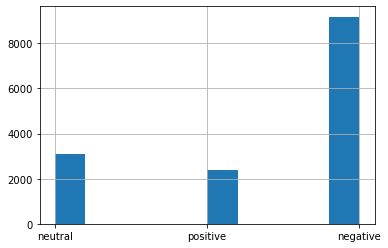

In [10]:
sentiment_df['airline_sentiment'].hist()

<strong style='color:red'>Class is imbalanced!</strong> Negative class overrepresented! <br/> <small>Note: Users may used social network to express dissatisfaction with a particular service.</small>

- Apply integer encoding

In [11]:
sentiment_encode = {
    'negative': 0, 
    'positive': 1, 
    'neutral': 2
}

In [12]:
sentiment_df['encoded_sentiment'] = sentiment_df['airline_sentiment'].map(sentiment_encode)

sentiment_df.head()

,airline_sentiment,text,encoded_sentiment
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


- Split the data into two subrecords:
<ul>
    <li>train (30%)</li>
    <li>test (70%)</li>
</ul>

In [13]:
df_train, df_test = train_test_split(sentiment_df, train_size = 0.30)

print(f'Number of train samples are: {len(df_train.index)}.\nNumber of test samles are: {len(df_test.index)}.')

Number of train samples are: 4392.
Number of test samles are: 10248.


- Get the last five records

In [14]:
df_train.tail()

,airline_sentiment,text,encoded_sentiment
6344,negative,@SouthwestAir Flight 4110 MCO to ISP delayed. ...,0
1580,neutral,@united If an award is no longer showing avail...,2
7027,negative,"Just in case you needed confirmation that ""on ...",0
10682,negative,@USAirways us air should be ashamed of this se...,0
10735,negative,@USAirways them and @AmericanAir,0


- Get the last five records

In [15]:
df_test.tail()

,airline_sentiment,text,encoded_sentiment
9279,neutral,@USAirways I need to email customer service f...,2
9318,negative,@USAirways your lack of customer service has s...,0
2521,negative,@united his cell phone record needs to be chec...,0
10764,neutral,@USAirways How do I redeem my pass to the admi...,2
2759,negative,@united Don't ask me to be patient without off...,0


- Create TD IDF vectorizer object (transforms the text into a usable vector)


<small><code>max_features</code> limits the vocabulary size of the model to 2000</small>

In [16]:
vectorizer = TfidfVectorizer(max_features = 2000)
vectorizer

TfidfVectorizer(max_features=2000)

- Fit vectorizer to the training data and transform it into <code>X_train</code>

In [17]:
X_train = vectorizer.fit_transform(df_train['text'])
X_train

<4392x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 63875 stored elements in Compressed Sparse Row format>

- Transform the test data into <code>X_test</code>

In [18]:
X_test = vectorizer.transform(df_test['text'])
X_test

<10248x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 144893 stored elements in Compressed Sparse Row format>

- Assign <code>Y_train</code> and <code>Y_test</code> to <code>encoded_sentiment</code> from previously integer encoded <code>airline_sentiment</code>

In [19]:
Y_train = df_train['encoded_sentiment']
Y_test = df_test['encoded_sentiment']

- print <code>df_train</code> data frame

In [20]:
df_train

,airline_sentiment,text,encoded_sentiment
12538,negative,"@AmericanAir @emxlyy ""The wheel was broken whe...",0
4668,positive,@SouthwestAir I'll stick with flying for free ...,1
12742,negative,"@AmericanAir thanks, but I had to hire a car i...",0
1483,negative,@united Why have you never held a plane for me...,0
986,negative,@united really? Someone called in sick and th...,0
...,...,...,...
6344,negative,@SouthwestAir Flight 4110 MCO to ISP delayed. ...,0
1580,neutral,@united If an award is no longer showing avail...,2
7027,negative,"Just in case you needed confirmation that ""on ...",0
10682,negative,@USAirways us air should be ashamed of this se...,0


- print <code>df_test</code> data frame

In [21]:
df_test

,airline_sentiment,text,encoded_sentiment
13926,negative,@AmericanAir delta rerouted 6 of my bags onto ...,0
10997,negative,"@USAirways please explain, I have plenty of ti...",0
2087,negative,@united we have tried to change our flight THR...,0
8873,neutral,@JetBlue I applied for a job at PDW where coul...,2
10224,negative,@USAirways You are 0 for 3 so far in on-time f...,0
...,...,...,...
9279,neutral,@USAirways I need to email customer service f...,2
9318,negative,@USAirways your lack of customer service has s...,0
2521,negative,@united his cell phone record needs to be chec...,0
10764,neutral,@USAirways How do I redeem my pass to the admi...,2


- Build a logistic reggression instace 

<small><code>max_iter</code> number of training processes taken to converge with the default values</small>

In [22]:
model = LogisticRegression(max_iter = 500)

- Fit the both train sets to the model

In [23]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=500)

- Print train set accuracy

In [24]:
print("Train acc:", model.score(X_train, Y_train))

Train acc: 0.855191256830601


- Print test set accuracy

In [25]:
print("Test acc:", model.score(X_test, Y_test))

Test acc: 0.7772248243559718


<small style='color:red'>Note: Both results cannot be interpreted in isolation since there are imbalanced classes</small>

- Check the AUC (infer the class probabilities)

In [26]:
Pr_train = model.predict_proba(X_train)
Pr_test = model.predict_proba(X_test)

- Print train AUC

In [27]:
print("Train AUC:", roc_auc_score(Y_train, Pr_train, multi_class = 'ovo'))

Train AUC: 0.9530153554742212


- Print test AUC

In [28]:
print("Test acc:", roc_auc_score(Y_test, Pr_test, multi_class = 'ovo'))

Test acc: 0.8787928554321


- Get the class labels predictions

In [29]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

- Call the confusion matrix function

In [30]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.97704448, 0.00466284, 0.01829268],
       [0.24613221, 0.69620253, 0.05766526],
       [0.34714446, 0.05151176, 0.60134378]])

- Plot the confusion matrix

In [31]:
classes = ['negative', 'positive', 'neutral'] 

Text(33.0, 0.5, 'Target')

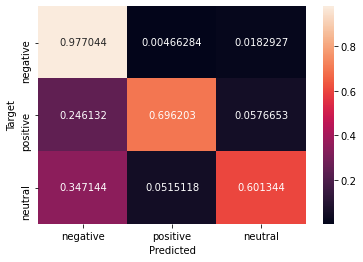

In [32]:
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

ax = sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

<ul>
    <li>Model do very well on negative class</li>
    <li>For positive class we get around 70 %</li>
    <li>When we do not predict the positive class corectly, we actually predict negative rather than neutral (it seems that there is a little chance of confusing positive tweets with neutral tweets)</li>
    <li>Predicting neutral is the worst. If we predict wrong neutral, it will be rather negative than positive</li>
</ul>

<small>Note: Model is biased towards the negative class as it is overrepsented class</small>

In [33]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
cm_test

array([[0.95962441, 0.0114241 , 0.02895149],
       [0.33535109, 0.53995157, 0.12469734],
       [0.52719855, 0.04623753, 0.42656392]])

Text(33.0, 0.5, 'Target')

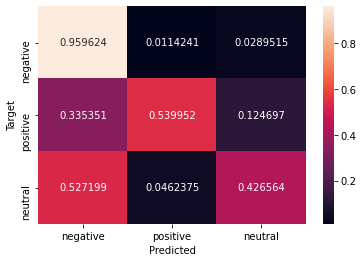

In [34]:
df_cm = pd.DataFrame(cm_test, index=classes, columns=classes)

ax = sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

<small style='color:red'>Performance is a bit worse! It's biased towards negative class.</small>

<h3>Train model without neutral class</h3>

- Take the samples that are classified as positive and negative

In [35]:
binary_target_list = [sentiment_encode['positive'], sentiment_encode['negative']]                    
binary_target_list        

[1, 0]

- Filter the rows with the <code>encoded_sentiment</code> equal to 2

In [36]:
df_b_train = df_train[df_train['encoded_sentiment'] != 2]
df_b_test = df_test[df_test['encoded_sentiment'] != 2]

print("Number of neutral airline_sentiment:", df_b_train.query('airline_sentiment == "neutral"')['airline_sentiment'].count())
print("Number of neutral airline_sentiment:", df_b_test.query('airline_sentiment == "neutral"')['airline_sentiment'].count())

Number of neutral airline_sentiment: 0
Number of neutral airline_sentiment: 0


- Print last five records

In [37]:
df_b_train.tail()

,airline_sentiment,text,encoded_sentiment
9767,negative,@USAirways why does this flight keep getting d...,0
6344,negative,@SouthwestAir Flight 4110 MCO to ISP delayed. ...,0
7027,negative,"Just in case you needed confirmation that ""on ...",0
10682,negative,@USAirways us air should be ashamed of this se...,0
10735,negative,@USAirways them and @AmericanAir,0


- Convert dataset into TD IDF vectorizer object

In [38]:
X_train = vectorizer.fit_transform(df_b_train["text"])
X_test = vectorizer.fit_transform(df_b_test["text"])

- Get the <code>encoded_sentiment</code> classes and obtain <code>Y_train</code> and <code>Y_test</code>

In [39]:
Y_train = df_b_train['encoded_sentiment']
Y_test = df_b_test['encoded_sentiment']

- Train a new model on binary dataset

In [40]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=500)

- Print the binary accuracy

In [41]:
print("Train acc:", model.score(X_train, Y_train))
print("Test acc:", model.score(X_test, Y_test))

Train acc: 0.9111174621320377
Test acc: 0.7838846058194479


- Compute the AUC

<small>Because we have binary classes, we only need one complement index 1 from the probabilities</small>

In [42]:
Pr_train = model.predict_proba(X_train)[:, 1]
Pr_test = model.predict_proba(X_test)[:, 1]

- Print the binary accuracy

In [43]:
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

Train AUC: 0.9790585834004283
Test AUC: 0.5829017892666735


- Obtain a weights from the trained model

In [44]:
model.coef_

array([[-0.0617696 , -0.14976316, -0.56141979, ...,  0.11191977,
         0.03613709, -0.37953891]])

- Plot the histogram of the weights

<small></small>

(array([  1.,   0.,   0.,   1.,   0.,   3.,   2.,   6.,   6.,  12.,  40.,
         88., 235., 875., 359., 202.,  82.,  47.,  21.,   5.,   2.,   1.,
          2.,   2.,   3.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([-3.42819902, -3.18465537, -2.94111171, -2.69756805, -2.45402439,
        -2.21048073, -1.96693707, -1.72339341, -1.47984975, -1.2363061 ,
        -0.99276244, -0.74921878, -0.50567512, -0.26213146, -0.0185878 ,
         0.22495586,  0.46849952,  0.71204317,  0.95558683,  1.19913049,
         1.44267415,  1.68621781,  1.92976147,  2.17330513,  2.41684878,
         2.66039244,  2.9039361 ,  3.14747976,  3.39102342,  3.63456708,
         3.87811074,  4.1216544 ,  4.36519805,  4.60874171,  4.85228537,
         5.09582903,  5.33937269,  5.58291635,  5.82646001,  6.07000367,
         6.31354732]),
 <BarContainer object of 40 artists>)

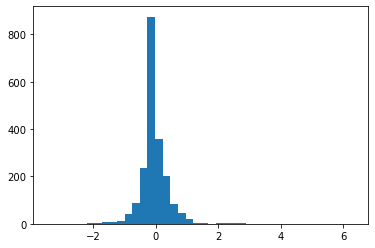

In [45]:
plt.hist(model.coef_[0], bins = 40)

- Obtain the words to index mapping because we won't know which words correspond to which input

In [46]:
word_index_map = vectorizer.vocabulary_
word_index_map 

{'americanair': 141,
 'delta': 516,
 'rerouted': 1461,
 'of': 1228,
 'my': 1181,
 'bags': 222,
 'onto': 1249,
 'mia': 1137,
 'how': 898,
 'can': 306,
 'see': 1533,
 'if': 917,
 'they': 1740,
 'made': 1089,
 'it': 964,
 'the': 1734,
 'flight': 719,
 'usairways': 1860,
 'please': 1339,
 'explain': 654,
 'have': 846,
 'plenty': 1340,
 'time': 1763,
 'since': 1574,
 'stranded': 1665,
 'united': 1842,
 'we': 1909,
 'tried': 1800,
 'to': 1769,
 'change': 340,
 'our': 1264,
 'three': 1752,
 'times': 1764,
 'on': 1242,
 'phone': 1316,
 'and': 146,
 'got': 808,
 'disconnected': 552,
 'each': 588,
 'you': 1994,
 'are': 173,
 'for': 746,
 'so': 1599,
 'far': 676,
 'in': 929,
 'flights': 730,
 'this': 1746,
 'vacation': 1871,
 'lost': 1069,
 'there': 1738,
 'was': 1897,
 'from': 765,
 'chi': 357,
 'that': 1732,
 'landed': 1003,
 'over': 1270,
 'hrs': 901,
 'ago': 110,
 'yet': 1992,
 'still': 1655,
 'zero': 1999,
 'updates': 1852,
 'jetblue': 972,
 'do': 560,
 'need': 1192,
 'late': 1009,
 'flightr

- Define the most extreme words for each class (find the words with the largest magnitudes of weights)

<small style='color:red'>Note: Words that have largest impact on the output.</small>
<small>

<p>There is no much words with the weight larger than two we'll try with different tresholds:</p>
<ul>
    <li>2</li>
    <li>1.5</li>
    <li>1.8</li>
</ul>
</small>

In [47]:
tresholds = [2, 1.5, 1.8]

- Print the most positive words

In [48]:
print("Most positive words:")

most_positive_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > tresholds[0]:
        most_positive_words[word] = weight
        print(word, weight)

Most positive words:
they 5.992355001506386
still 2.532919702956886
works 2.054260047536216
inflight 2.4919011737136194
awesome 2.9001334647718817
generic 2.016274064044278
give 2.922065002337304
believe 2.5545318666531927
things 6.313547324646913
alternate 2.41409127423671
walk 2.3036756027805225
london 2.6792678766710414


In [49]:
print("Most positive words:")

most_positive_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > tresholds[1]:
        most_positive_words[word] = weight
        print(word, weight)

Most positive words:
they 5.992355001506386
still 2.532919702956886
works 2.054260047536216
inflight 2.4919011737136194
awesome 2.9001334647718817
generic 2.016274064044278
give 2.922065002337304
believe 2.5545318666531927
anywhere 1.7768347472479922
things 6.313547324646913
alternate 2.41409127423671
walk 2.3036756027805225
smooth 1.5403445000409843
london 2.6792678766710414


In [50]:
print("Most positive words:")

most_positive_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > tresholds[2]:
        most_positive_words[word] = weight
        print(word, weight)

Most positive words:
they 5.992355001506386
still 2.532919702956886
works 2.054260047536216
inflight 2.4919011737136194
awesome 2.9001334647718817
generic 2.016274064044278
give 2.922065002337304
believe 2.5545318666531927
things 6.313547324646913
alternate 2.41409127423671
walk 2.3036756027805225
london 2.6792678766710414


<small>Some words may be the names of the airlines which means that these are associated with positive feedback!</small>

In [51]:
most_positive_words_df = pd.DataFrame.from_dict(most_positive_words, orient='index', columns=['weight'])

most_positive_words_df

,weight
they,5.992355
still,2.532920
works,2.054260
inflight,2.491901
awesome,2.900133
generic,2.016274
give,2.922065
believe,2.554532
things,6.313547
alternate,2.414091


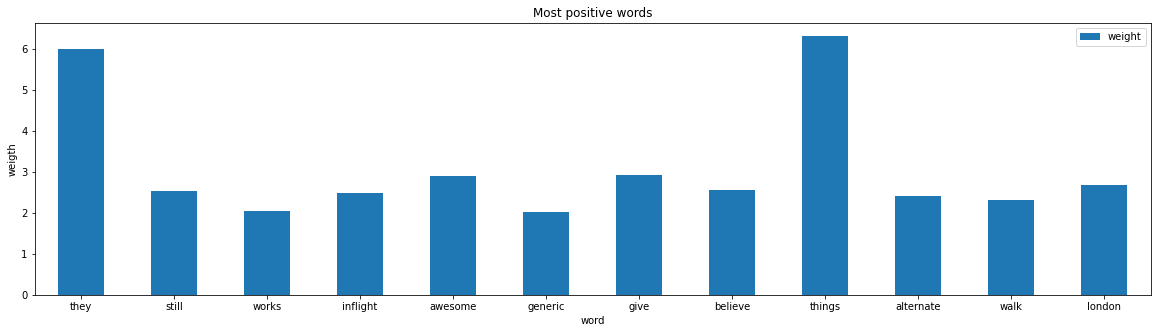

In [52]:
most_positive_words_df.plot.bar(rot=0, figsize=(20,5))

plt.title('Most positive words')
plt.xlabel('word')
plt.ylabel('weigth')

plt.show()

Wordcloud for most positive words


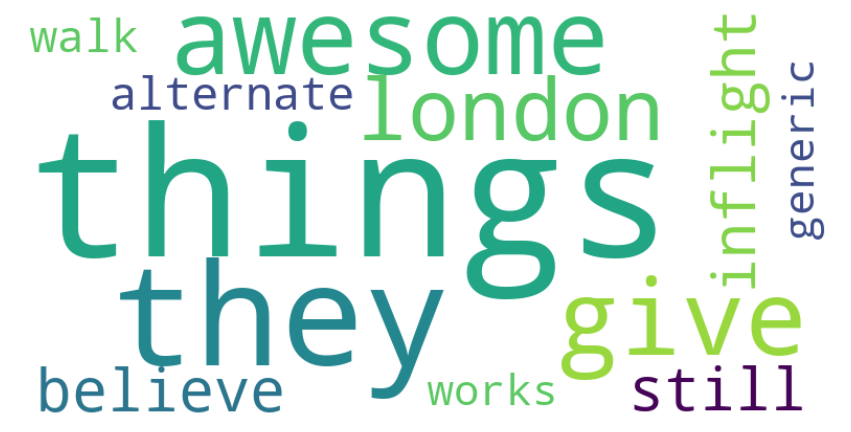

In [53]:
print("Wordcloud for most positive words")

positive_wordcloud = WordCloud(background_color="white", width=800, height=400)
positive_wordcloud.generate_from_frequencies(most_positive_words)
plt.figure(figsize=(15,10))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

- Print the most negative words

In [54]:
print("Most negative words:")

most_negative_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < - tresholds[0]:
        most_negative_words[word] = weight
        print(word, weight)

Most negative words:
no -2.4959578449606075
nothing -3.4281990246135243
impossible -2.005408170507468
her -2.037290780271605
dallas -2.037660970424201


In [55]:
print("Most negative words:")

most_negative_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < - tresholds[2]:
        most_negative_words[word] = weight
        print(word, weight)

Most negative words:
no -2.4959578449606075
nothing -3.4281990246135243
wife -1.8766202939860512
impossible -2.005408170507468
her -2.037290780271605
dallas -2.037660970424201
came -1.9360871540698879


In [56]:
print("Most negative words:")

most_negative_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < - tresholds[1]:
        most_negative_words[word] = weight
        print(word, weight)

Most negative words:
no -2.4959578449606075
nothing -3.4281990246135243
wife -1.8766202939860512
impossible -2.005408170507468
cabin -1.5965008983308842
her -2.037290780271605
worries -1.6017983070540553
whenever -1.6937375053252572
heading -1.6566538347185595
dallas -2.037660970424201
came -1.9360871540698879
value -1.5167074355001944


In [57]:
most_negative_words_df = pd.DataFrame.from_dict(most_negative_words, orient='index', columns=['weight'])

most_negative_words_df

,weight
no,-2.495958
nothing,-3.428199
wife,-1.876620
impossible,-2.005408
cabin,-1.596501
her,-2.037291
worries,-1.601798
whenever,-1.693738
heading,-1.656654
dallas,-2.037661


<small>Words like: hours, now, and will are words that have low weight. That means that (unfulfilled) promises are time-consuming, and one of the most relevant factors of good service is the time in which the service is delivered.</small>

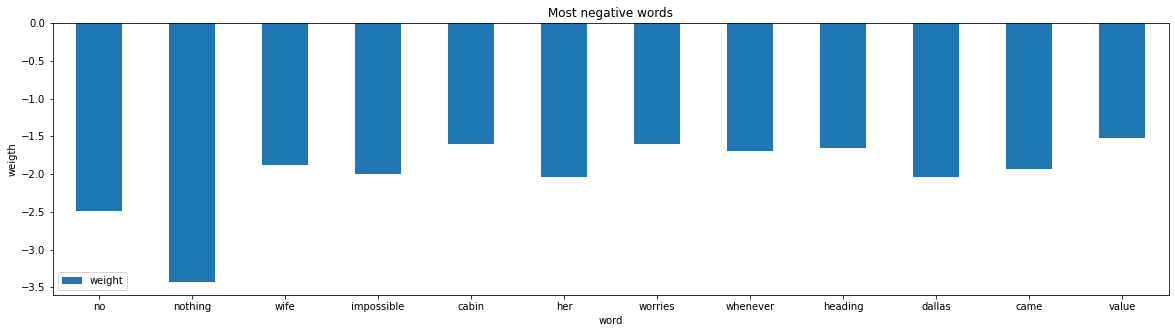

In [58]:
most_negative_words_df.plot.bar(rot=0, figsize=(20,5))

plt.title('Most negative words')
plt.xlabel('word')
plt.ylabel('weigth')

plt.show()

Wordcloud for most negative words


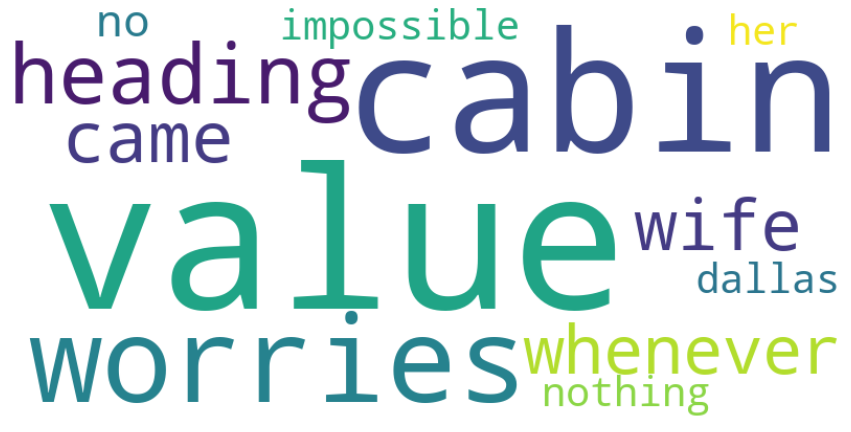

In [59]:
print("Wordcloud for most negative words")

negative_wordcloud = WordCloud(background_color="white", width=800, height=400)
negative_wordcloud.generate_from_frequencies(most_negative_words)
plt.figure(figsize=(15,10))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

- Filter out stopwords

In [60]:
stop = stopwords.words('english')

most_positive_words_without_stop_words = [word for word in most_positive_words_df.index if word not in stopwords.words('english')]
most_negative_words_without_stop_words = [word for word in most_negative_words_df.index if word not in stopwords.words('english')]

print("Before:", len(most_positive_words), len(most_negative_words))
print("After:", len(most_positive_words_without_stop_words), len(most_negative_words_without_stop_words))



Before: 12 12
After: 11 10


In [61]:
filtered_df = pd.DataFrame();
filtered_df['State'] = ["Before", "After"]
filtered_df['Positive'] = [len(most_positive_words), len(most_negative_words)]
filtered_df['Negative'] = [len(most_positive_words_without_stop_words), len(most_negative_words_without_stop_words)]

filtered_df

,State,Positive,Negative
0,Before,12,11
1,After,12,10
